In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob

from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from time import sleep

import sys

SEED = 10

CURRPATH = os.getcwd()
DATAPATH = '\\'.join(CURRPATH.split('\\')[:-1]) + '\\data.csv'
CODESPATH = '\\'.join(CURRPATH.split('\\')[:-1]) + '\\codes'

if CODESPATH not in sys.path:
    sys.path.append(CODESPATH)

from visualization import draw_wordcloud, draw_cluster_clouds
from sklearn.cluster import KMeans
import gensim
from gensim.models import Word2Vec

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%load_ext autoreload

# В этом ноутбуке мы решаем задачу кластеризации как supervised и подбираем оптимальные гиперпараметры для наилучшего решения, оцениваем ее качество разными способами, используя разметку.

In [3]:
df = pd.read_csv(DATAPATH)
df

univ                                        prog  \
0      АГТУ  ИИТиК_информатика и вычислительная техника   
1      АГТУ  ИИТиК_информатика и вычислительная техника   
2      АГТУ  ИИТиК_информатика и вычислительная техника   
3      АГТУ  ИИТиК_информатика и вычислительная техника   
4      АГТУ  ИИТиК_информатика и вычислительная техника   
...     ...                                         ...   
4373  ИМСИТ                экономика финансы и учёт 3++   
4374  ИМСИТ                экономика финансы и учёт 3++   
4375  ИМСИТ                экономика финансы и учёт 3++   
4376  ИМСИТ                экономика финансы и учёт 3++   
4377  ИМСИТ                экономика финансы и учёт 3++   

                                                   name  \
0                 администрирование операционных систем   
1                                   алгебра и геометрия   
2                          алгоритмы и структуры данных   
3     архитектура вычислительных систем, операционны...   
4                        безопасность жизнедеятельности   
...                                                 ...   
4373                                            финансы   
4374                                       эконометрика   
4375                  экономика предприятия организации   
4376                          экономическая информатика   
4377                               экономическая теория   

                                                   text  \
0     администрирование операционный разрабатывать б...   
1     алгебра геометрия естественнонаучный общеинжен...   
2     разрабатывать программа пригодный алгоритмичес...   
3     архитектура вычислительный операционный число ...   
4     жизнедеятельность создавать поддерживать повсе...   
...                                                 ...   
4373  финансы будущий профессия конечный функциониро...   
4374  эконометрика эконометрический количественный к...   
4375  нацеливать хозяйствовать организационно-правов...   
4376  информатика вычислительный машина вычислительн...   
4377  нацеливать совершенствование дальнейший мотив ...   

                            cluster  
0     программирование и разработка  
1                        математика  
2                       информатика  
3     программирование и разработка  
4                               бжд  
...                             ...  
4373            экономика и финансы  
4374                     математика  
4375            экономика и финансы  
4376                    информатика  
4377            экономика и финансы  

[4378 rows x 5 columns]

In [4]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder().fit(df.cluster)
df.cluster = LE.transform(df.cluster)
clusters = dict(zip([_ for _ in range(len(LE.classes_))], LE.classes_))
df

univ                                        prog  \
0      АГТУ  ИИТиК_информатика и вычислительная техника   
1      АГТУ  ИИТиК_информатика и вычислительная техника   
2      АГТУ  ИИТиК_информатика и вычислительная техника   
3      АГТУ  ИИТиК_информатика и вычислительная техника   
4      АГТУ  ИИТиК_информатика и вычислительная техника   
...     ...                                         ...   
4373  ИМСИТ                экономика финансы и учёт 3++   
4374  ИМСИТ                экономика финансы и учёт 3++   
4375  ИМСИТ                экономика финансы и учёт 3++   
4376  ИМСИТ                экономика финансы и учёт 3++   
4377  ИМСИТ                экономика финансы и учёт 3++   

                                                   name  \
0                 администрирование операционных систем   
1                                   алгебра и геометрия   
2                          алгоритмы и структуры данных   
3     архитектура вычислительных систем, операционны...   
4                        безопасность жизнедеятельности   
...                                                 ...   
4373                                            финансы   
4374                                       эконометрика   
4375                  экономика предприятия организации   
4376                          экономическая информатика   
4377                               экономическая теория   

                                                   text  cluster  
0     администрирование операционный разрабатывать б...       10  
1     алгебра геометрия естественнонаучный общеинжен...        7  
2     разрабатывать программа пригодный алгоритмичес...        3  
3     архитектура вычислительный операционный число ...       10  
4     жизнедеятельность создавать поддерживать повсе...        1  
...                                                 ...      ...  
4373  финансы будущий профессия конечный функциониро...       17  
4374  эконометрика эконометрический количественный к...        7  
4375  нацеливать хозяйствовать организационно-правов...       17  
4376  информатика вычислительный машина вычислительн...        3  
4377  нацеливать совершенствование дальнейший мотив ...       17  

[4378 rows x 5 columns]

In [5]:
clusters

{0: 'ИБ/КБ',
 1: 'бжд',
 2: 'бизнес, менеджмент и маркетинг',
 3: 'информатика',
 4: 'иняз',
 5: 'история и политика',
 6: 'компьютерная графика и дизайн',
 7: 'математика',
 8: 'медиа и реклама',
 9: 'право',
 10: 'программирование и разработка',
 11: 'прочее',
 12: 'психология, социология и приложения',
 13: 'сети и системы',
 14: 'спорт',
 15: 'физика и химия',
 16: 'химия, биология, экология и география',
 17: 'экономика и финансы',
 18: 'языки'}

## Как оценивать качество кластеризации и факторизации?
Проблема в том, что любой объект выборки относится строго к одной сущности. Мы можем получить в целом хорошую кластеризацию, но плохую факторизацию (напомню, что факторизация -- это кластеризация конкретной образовательной программы). Таким образом, нужно рассматривать разные варианты:
* Оценка качества кластеризации: B-Cubed;
* Оценка качества факторизации: средняя метрика по всем направлениям.

Таким образом, мы будем учить модель на кластеризацию, а оценивать качество по факторизации отдельных направлений подготовки.

Разделим выборку следующим образом: train и valid для кластеризации, тестовые направления для оценки качества факторизации.

In [6]:
np.random.seed(SEED)
progs = df['prog'].unique().tolist()
inds = np.random.choice(len(progs), size=30, replace=False)

In [7]:
def build_df(inds_):
    new_df = pd.DataFrame()
    for ind in inds_:
        tmp_df = df[df.prog == progs[ind]]
        new_df = new_df.append(tmp_df, ignore_index=True)
    return new_df

In [8]:
df_test_fact = build_df(inds)
df_test_fact

univ                               prog  \
0     ВолГУ  мировые политические процессы 3++   
1     ВолГУ  мировые политические процессы 3++   
2     ВолГУ  мировые политические процессы 3++   
3     ВолГУ  мировые политические процессы 3++   
4     ВолГУ  мировые политические процессы 3++   
...     ...                                ...   
1318  АлтГУ         юриспруденция общеправовой   
1319  АлтГУ         юриспруденция общеправовой   
1320  АлтГУ         юриспруденция общеправовой   
1321  АлтГУ         юриспруденция общеправовой   
1322  АлтГУ         юриспруденция общеправовой   

                                                   name  \
0         введение в практический курс корейского языка   
1     визуализация результатов исследований в област...   
2                 государственная политика и управление   
3                     иностранный язык второй испанский   
4                      иностранный язык второй немецкий   
...                                                 ...   
1318                                   финансовое право   
1319                                  цифровая культура   
1320                                экологическое право   
1321                                юридическая клиника   
1322                             юридическая психология   

                                                   text  cluster  
0     корейский письмо чтение пользоваться языковый ...       18  
1     презентация экспертный-аналитический предъявля...        5  
2     структурно-функциональный институциональный пр...        5  
3     иноязычный лингвистический дискурсивный социол...       18  
4     иноязычный лингвистический дискурсивный социол...       18  
...                                                 ...      ...  
1318  заключаться объем необходимо определенный буду...        9  
1319  очередь функционал грамотно быт баз машинный г...       11  
1320  экологический высококвалифицированный юрист об...        9  
1321  клиника оказание бесплатный социально незащище...        9  
1322  квалифицированный усваивать психика психически...        9  

[1323 rows x 5 columns]

In [9]:
from sklearn.model_selection import train_test_split

y = df.cluster
df_train, df_test, y_train, y_test = train_test_split(df.drop('cluster', axis=1), y, 
                                                      random_state=SEED, test_size=0.2, stratify=y)

In [10]:
N_CLUSTERS = len(clusters)

In [11]:
corpus_all = [text.split() for text in df.text.tolist()]
corpus_test = [text.split() for text in df_test.text.tolist()]
corpus_train = [text.split() for text in df_train.text.tolist()]

## Метрика
В качестве метрики будем использовать `B-Cubed`, так как она отвечает всем требованиям аксессоров: `гомогенность`, `полнота`, `rag-bag` и `size vs quantity`. Пусть для объекта $x_i$ верный ответ $y_i$ (по разметке), ответ кластеризации $a(x_i)$, тогда `B-Cubed` определяется следующим образом:

$$\text{Correctness}(x_i, x_j) = [y_i = y_j] \cdot [a(x_i) = a(x_j)]$$

$$\text{Precision}(y, a(x)) = \frac{1}{\ell}\sum\limits_{i=1}^{\ell}\underset{j: a(x_i) = a(x_j)}{\text{Average}}\ \text{Correctness}(x_i, x_j)$$

$$\text{Recall}(y, a(x)) = \frac{1}{\ell}\sum\limits_{i=1}^{\ell}\underset{j: y_i = y_j}{\text{Average}}\ \text{Correctness}(x_i, x_j)$$

$$\text{F-Score}(y, a(x)) = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [12]:
from metrics import BCubed
bcubed = BCubed()

## Подбор гиперапараметров с помощью `optuna`

In [13]:
from utils import idf_mean_vectorizer
from scipy.sparse.csr import csr_matrix

class ClusteringModel(object):
    
    def __init__(self, transformer, clusterer, transformer_kwargs=None, clusterer_kwargs=None, is_wmodel_fitted=False):
        if is_wmodel_fitted:
            self.w_model = transformer
        else:
            self.w_model = transformer(**transformer_kwargs) if transformer_kwargs is not None else transformer()
        self.clusterer = clusterer(**clusterer_kwargs) if clusterer_kwargs is not None else clusterer()
        self.is_wmodel_fitted = is_wmodel_fitted
        
        
    def fit(self, X, with_='both'):
        '''
            with_ is ['transformer', 'clusterer', 'both'] -- to fit
        '''
        if not self.is_wmodel_fitted:
            if with_ == 'transformer' or with_ == 'both':
                assert all(type(elem) == list for elem in X)
                self.w_model.build_vocab(X)
                self.w_model.train(X, total_examples=self.w_model.corpus_count, epochs=self.w_model.epochs)
                   
        if with_ == 'both':
            X = self.transform(X)
            
        if with_ == 'clusterer' or with_ == 'both':        
            assert type(X) == np.array or type(X) == csr_matrix
            self.clusterer = self.clusterer.fit(X)
            
        return self
    
        
    def predict(self, X):
        assert hasattr(self.clusterer, 'predict')
        assert type(X) == np.array or type(X) == csr_matrix
        return self.clusterer.predict(X)
        
        
    def transform(self, X):
        assert all(type(elem) == list for elem in X)
        corpus_X = [' '.join(text) for text in X]
        wmodel_dict = dict(zip(self.w_model.wv.index_to_key, self.w_model.wv.vectors))
        sparse_matrix = idf_mean_vectorizer(wmodel_dict).fit_transform(corpus_X)
        return sparse_matrix
        
        
    def fit_predict(self, X):
        if self.is_wmodel_fitted:
            if all(type(elem) == list for elem in X):
                return self.clusterer.fit_predict(self.transform(X))
            else:
                return self.clusterer.fit_predict(X)
        else:
            assert all(type(elem) == list for elem in X)
            self = self.fit(X, with_='both')
            return self.predict(self.transform(X))
            
        
    def fit_transform(self, X):
        assert all(type(elem) == list for elem in X)
        if not self.is_wmodel_fitted:
            self = self.fit(X, with_='transformer')
        return transform(self, X)
    
    def transform_predict(self, X):
        assert all(type(elem) == list for elem in X)
        return self.predict(self.transform(X))

In [14]:
import optuna
import multiprocessing
cores = multiprocessing.cpu_count()
print('cores available: {}'.format(cores))

ALL_MODELS, ALL_KWARGS = [], []

def objective(trial, ALL_MODELS=ALL_MODELS, ALL_KWARGS=ALL_KWARGS):
    w2v_kwargs = {
        'vector_size':trial.suggest_int('vector_size', 500, 3000, step=500),
        'window':trial.suggest_int('window', 5, 20, step=5),
        'epochs':trial.suggest_int('epochs', 5, 25, step=5),
        'negative':trial.suggest_int('negative', 0, 50, step=10),
        'hs':trial.suggest_categorical('hs', [0, 1]),
        
        'sg':1,
        'workers':cores - 2,
        'seed':SEED,
    }
    
    clusterer_kwargs = {
        'init':trial.suggest_categorical('init', ['random', 'k-means++']),
        'tol':trial.suggest_categorical('tol', [1e-4, 1e-5, 1e-6, 1e-7]),
        'algorithm':trial.suggest_categorical('algorithm', ['lloyd', 'elkan']),
        'max_iter':trial.suggest_int('max_iter', 100, 350, step=50),
        
        'random_state':SEED,
        'n_clusters':trial.suggest_int('n_clusters', round(0.8 * N_CLUSTERS), round(1.3 * N_CLUSTERS), step=2),
    }
    
    find_ind = next((i for i in range(len(ALL_KWARGS)) if ALL_KWARGS[i] == w2v_kwargs), None)    
    
    if find_ind is not None:
        model = ClusteringModel(ALL_MODELS[find_ind], KMeans, w2v_kwargs, clusterer_kwargs, True)
    else:
        model = ClusteringModel(Word2Vec, KMeans, w2v_kwargs, clusterer_kwargs)
        ALL_MODELS += [model.w_model]
        ALL_KWARGS += [w2v_kwargs]
        model = model.fit(corpus_all, 'transformer')
        
    mat = model.transform(corpus_train)
    model = model.fit(mat, 'clusterer')
    labels_test = model.transform_predict(corpus_test)

    return bcubed.fscore(np.asarray(y_test), np.asarray(labels_test))

cores available: 8


In [15]:
study = optuna.create_study(study_name='w2v_kmeans', direction="maximize")
study.optimize(objective, n_trials=50, timeout=3600 * 12)

[I 2022-07-21 10:16:14,310] A new study created in memory with name: w2v_kmeans
[I 2022-07-21 10:38:17,051] Trial 0 finished with value: 0.5234884195687166 and parameters: {'vector_size': 1500, 'window': 10, 'epochs': 20, 'negative': 25, 'hs': 0, 'init': 'random', 'tol': 0.0001, 'algorithm': 'elkan', 'max_iter': 100, 'n_clusters': 17}. Best is trial 0 with value: 0.5234884195687166.
[I 2022-07-21 10:47:22,476] Trial 1 finished with value: 0.5114455505648403 and parameters: {'vector_size': 2500, 'window': 5, 'epochs': 5, 'negative': 25, 'hs': 1, 'init': 'k-means++', 'tol': 1e-05, 'algorithm': 'elkan', 'max_iter': 250, 'n_clusters': 23}. Best is trial 0 with value: 0.5234884195687166.
[I 2022-07-21 10:57:18,092] Trial 2 finished with value: 0.5253364742942226 and parameters: {'vector_size': 3000, 'window': 5, 'epochs': 25, 'negative': 5, 'hs': 0, 'init': 'k-means++', 'tol': 1e-07, 'algorithm': 'elkan', 'max_iter': 300, 'n_clusters': 15}. Best is trial 2 with value: 0.5253364742942226.
[I

[I 2022-07-21 15:32:51,643] Trial 26 finished with value: 0.5306670067580287 and parameters: {'vector_size': 1000, 'window': 5, 'epochs': 5, 'negative': 15, 'hs': 1, 'init': 'random', 'tol': 0.0001, 'algorithm': 'lloyd', 'max_iter': 250, 'n_clusters': 15}. Best is trial 23 with value: 0.5614014651162992.
[I 2022-07-21 16:08:40,533] Trial 27 finished with value: 0.5127103416876666 and parameters: {'vector_size': 1500, 'window': 15, 'epochs': 20, 'negative': 25, 'hs': 1, 'init': 'random', 'tol': 1e-06, 'algorithm': 'lloyd', 'max_iter': 350, 'n_clusters': 19}. Best is trial 23 with value: 0.5614014651162992.
[I 2022-07-21 16:09:50,889] Trial 28 finished with value: 0.5129940760003792 and parameters: {'vector_size': 2500, 'window': 20, 'epochs': 10, 'negative': 20, 'hs': 0, 'init': 'k-means++', 'tol': 1e-05, 'algorithm': 'elkan', 'max_iter': 150, 'n_clusters': 17}. Best is trial 23 with value: 0.5614014651162992.
[I 2022-07-21 16:16:12,708] Trial 29 finished with value: 0.5727954731034127 

C:\Users\Oleg\AppData\Local\Temp/ipykernel_13692/1974320164.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_plt.plot_optimization_history(study);


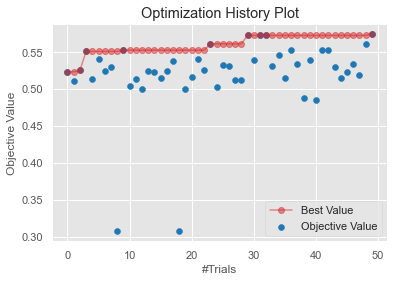

In [16]:
import optuna.visualization.matplotlib as optuna_plt
optuna_plt.plot_optimization_history(study);

In [17]:
trial = study.best_trial
print("Best trial:\n\tValue: {}".format(trial.value))

Best trial:
	Value: 0.5750660768049177


Значение метрики на тесте получилось невпечатляющим, однако это вовсе не говорит о том, что кластеризация получилось плохой. **Основной момент** заключается в том, что полученная кластеризация не очень близка к разметке. Учитывая то, что **разметка многовариативна**, следует иметь в виду, что при другой разметке и при тех же алгоритмах (и их параметрах) значение `B-Cubed` может получиться выше.

In [19]:
trial.params

{'vector_size': 1500,
 'window': 15,
 'epochs': 5,
 'negative': 15,
 'hs': 0,
 'init': 'random',
 'tol': 1e-07,
 'algorithm': 'elkan',
 'max_iter': 150,
 'n_clusters': 21}

In [26]:
kmeans_kwargs = {
     'init': 'random',
     'tol': 1e-07,
     'algorithm': 'elkan',
     'max_iter': 150,
     'n_clusters': 21,
     'random_state':SEED,
    }

w2v_kwargs = {
     'vector_size': 1500,
     'window': 15,
     'epochs': 5,
     'negative': 15,
     'hs': 0,
     'sg':1,
     'workers':cores - 2,
     'seed':SEED,
    }

# Оценка качества
## Оценка качества кластеризации
Посмотрим, как выглядит кластеризация с полученными гиперпараметрами на всей выборке.

In [27]:
find_ind = next((i for i in range(len(ALL_KWARGS)) if ALL_KWARGS[i] == w2v_kwargs), None)    
model = ClusteringModel(ALL_MODELS[find_ind], KMeans, w2v_kwargs, kmeans_kwargs, True)
labels_all = model.transform_predict(corpus_all)

cluster: 1; samples: 240


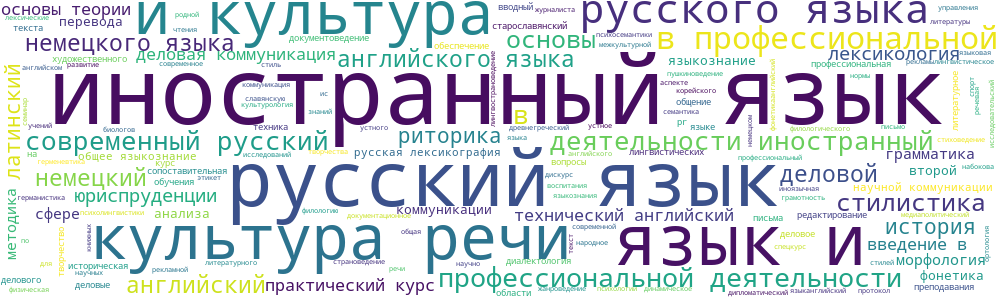

cluster: 2; samples: 299


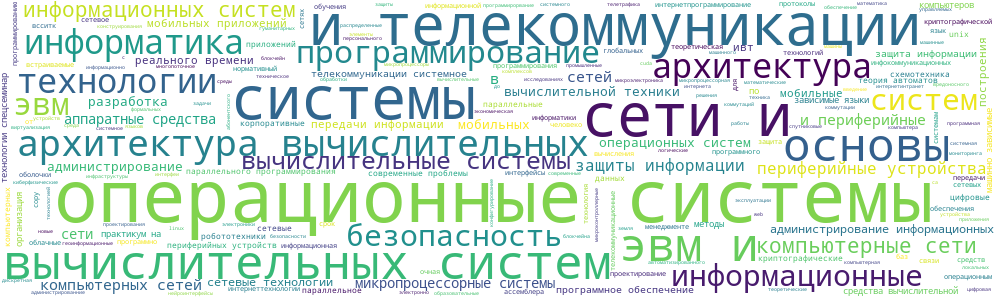

cluster: 3; samples: 80


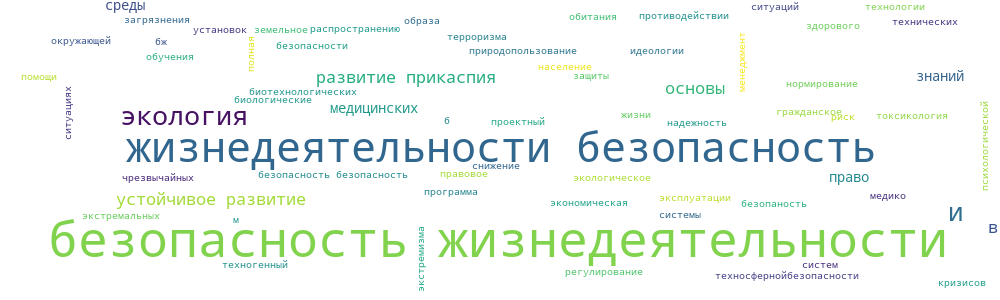

cluster: 4; samples: 253


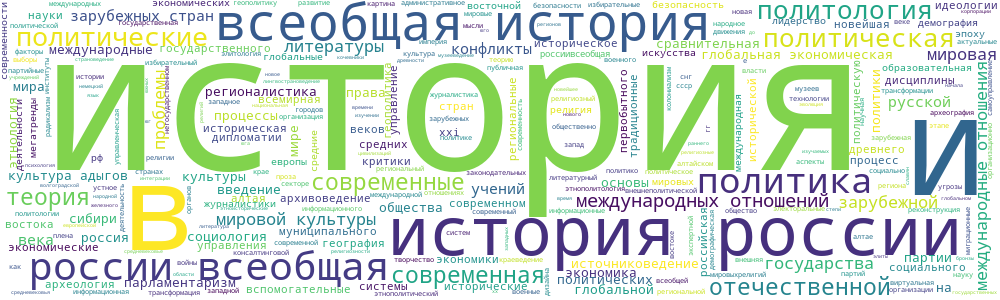

cluster: 5; samples: 108


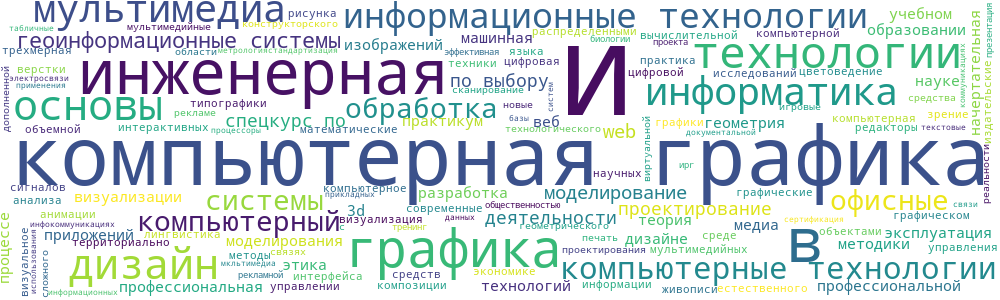

cluster: 6; samples: 182


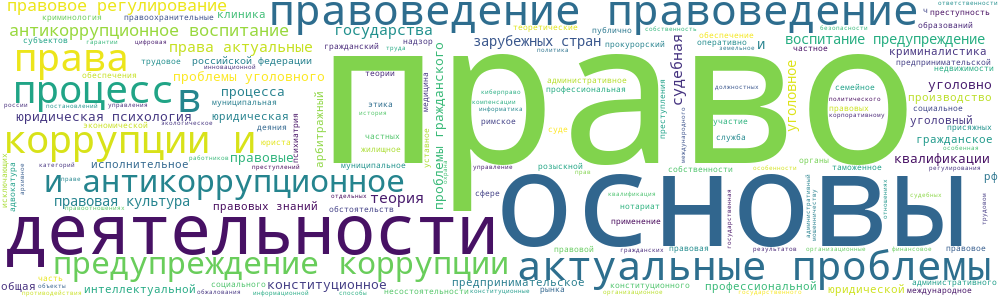

cluster: 7; samples: 197


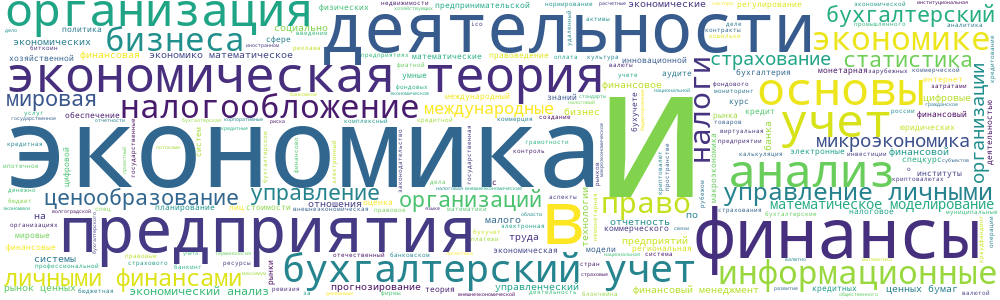

cluster: 8; samples: 382


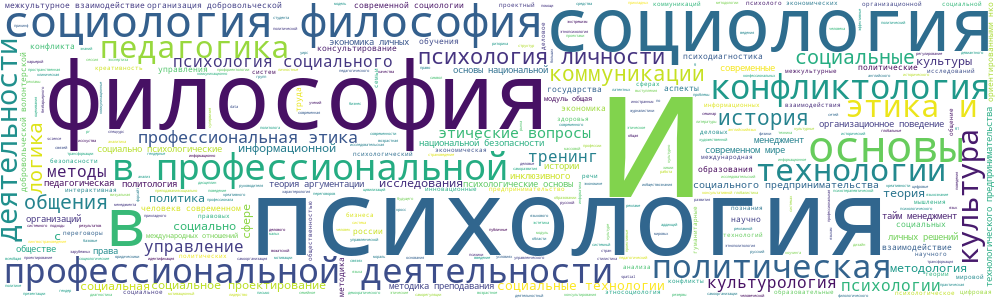

cluster: 9; samples: 458


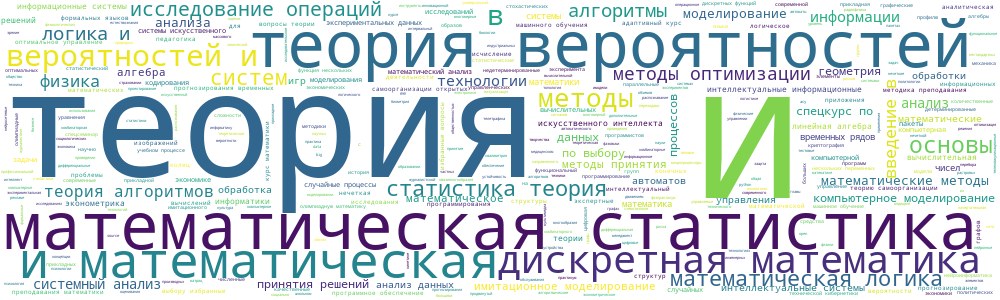

cluster: 10; samples: 126


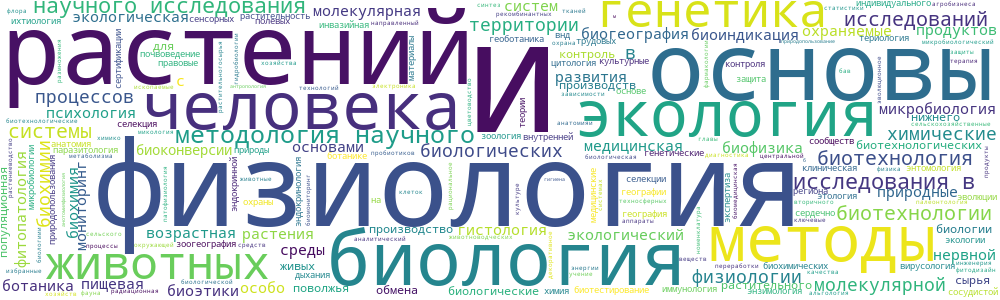

cluster: 11; samples: 44


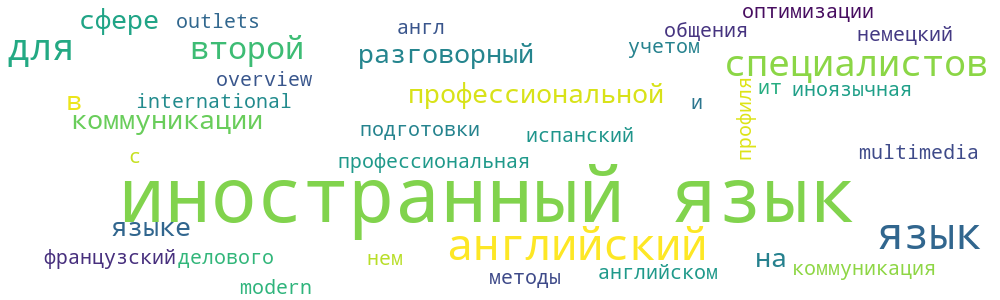

cluster: 12; samples: 371


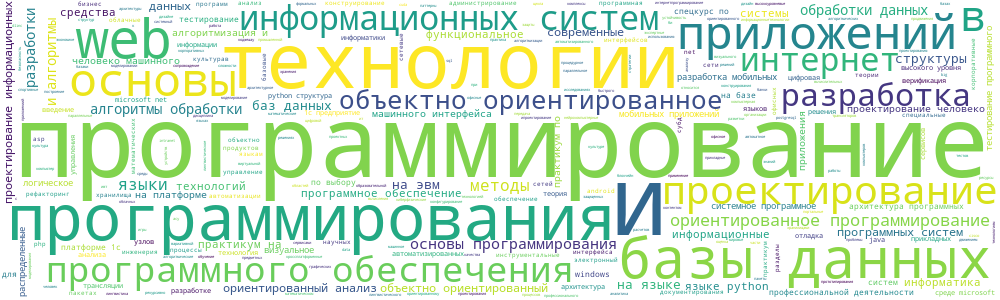

cluster: 13; samples: 116


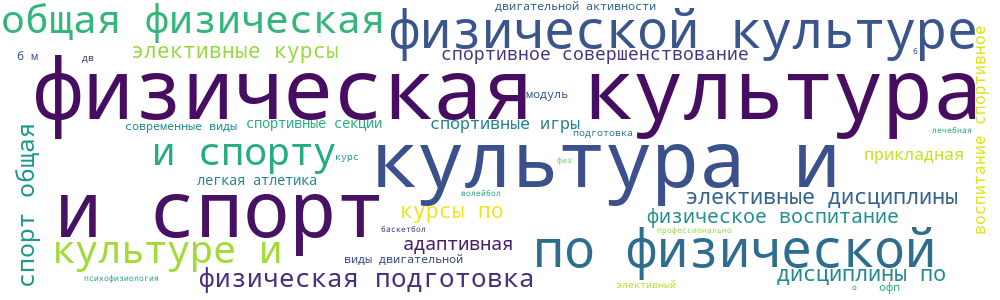

cluster: 14; samples: 61


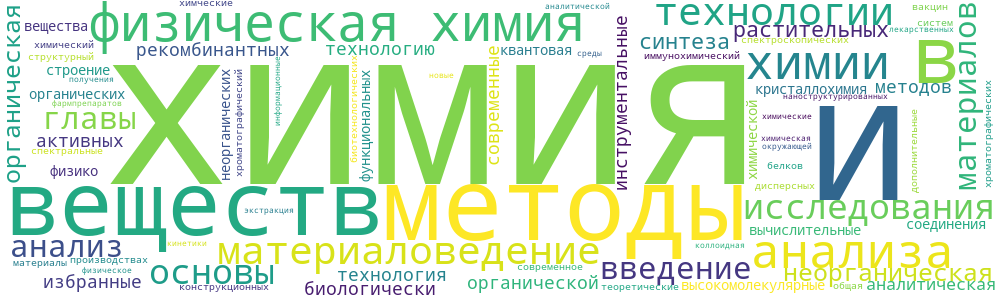

cluster: 15; samples: 265


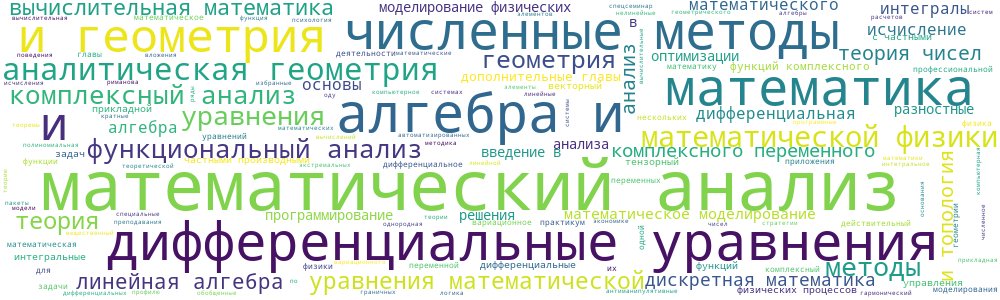

cluster: 16; samples: 121


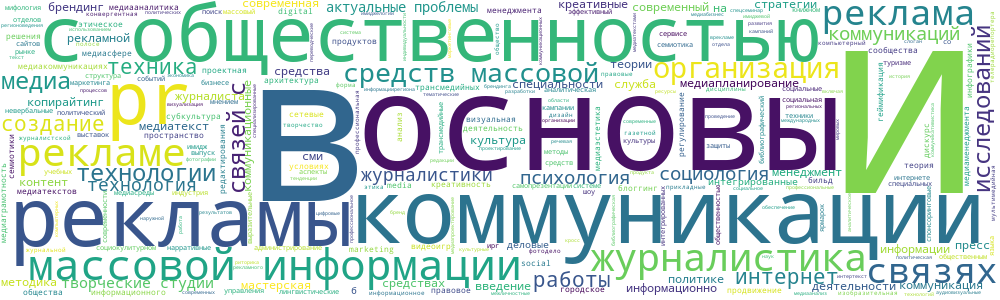

cluster: 17; samples: 103


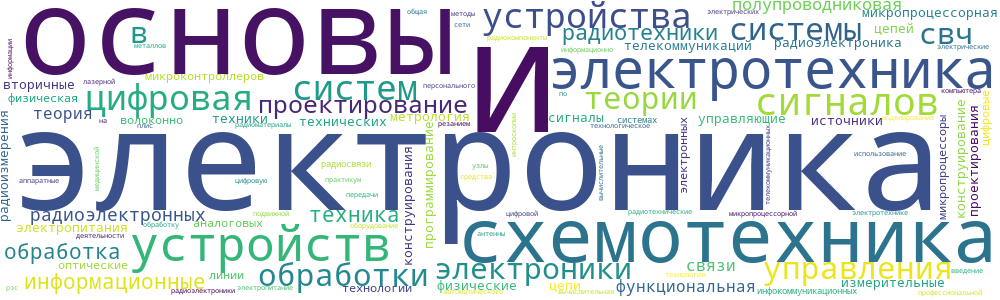

cluster: 18; samples: 40


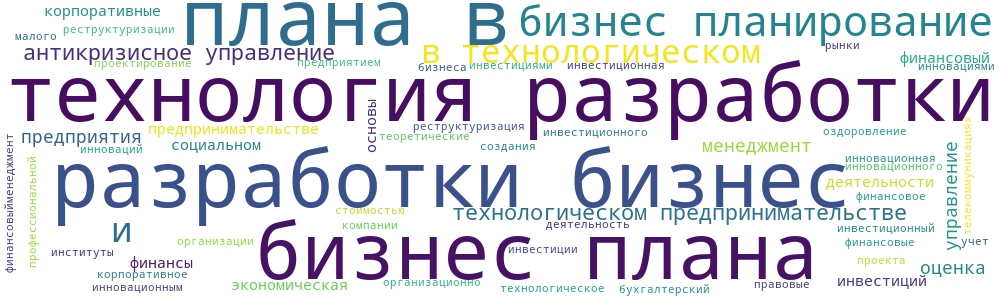

cluster: 19; samples: 135


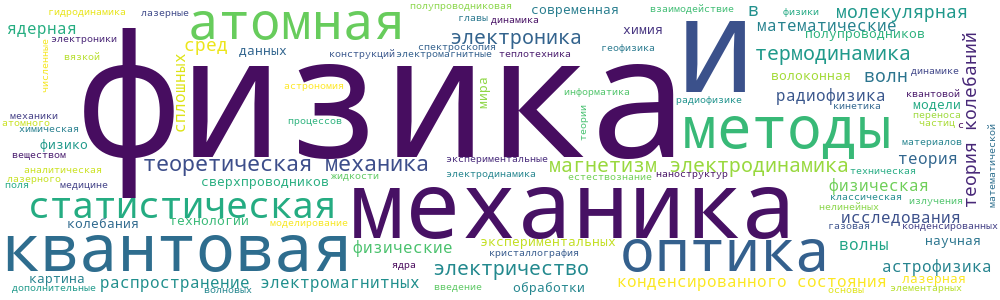

cluster: 20; samples: 213


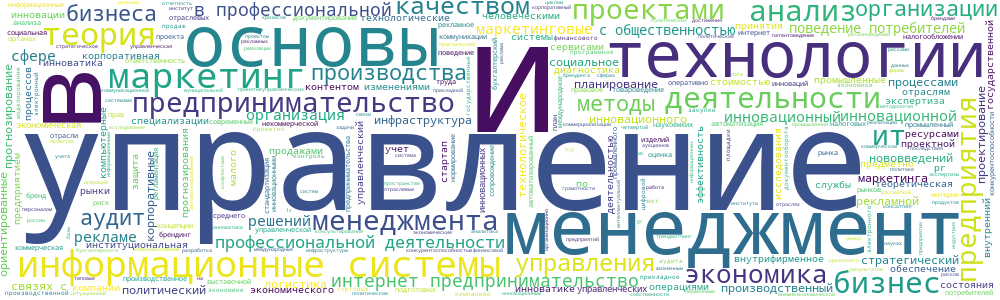

cluster: 21; samples: 584


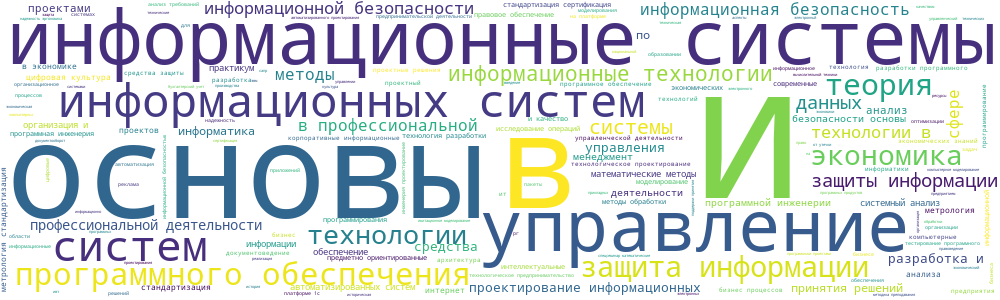

In [29]:
cloud_kwargs = { 'max_words':2000, 'width':1000, 'height':300 }
draw_cluster_clouds(df, labels_all, kmeans_kwargs['n_clusters'], alert_by='name', cloud_kwargs=cloud_kwargs)

Кластеризация получилась действительно очень хорошей: выделились примерно те кластеры, которые и задавались в разметке. Первое, что бросается в глаза -- кластер математики разделен на два больших раздела: высшая математика и теория вероятностей и математическая статистика. Кластер физики и химии также разделился на три: техника, физика (как предмет) и химия отдельно.

Негативный момент заключается в том, что, например, некоторые кластеры смешались -- так произошло в случае с кластером ИБ/КБ.

В теории такая проблема может решиться путем лучшей очистки текстов.

In [34]:
model.w_model.save("w2v_skip.model")

## Оценка качества факторизации.
Как и было сказано ранее -- для каждого (тестового) направления получим факторизацию и оценим ее качество, после чего усредним для всех направлений.

In [58]:
inds = df_test_fact.index
df_test_fact['predicted'] = np.asarray(labels_all)[inds]

In [62]:
bcs = [] 
for prog in df_test_fact.prog.unique():
    tmp = df_test_fact[df_test_fact.prog == prog]
    true_fact = np.asarray(tmp.cluster)
    predicted_fact = np.asarray(tmp.predicted)
    bcs += [bcubed.fscore(true_fact, predicted_fact)]

In [63]:
np.mean(bcs)

0.4162145326944858

In [108]:
bcs

[0.45574305942481985,
 0.3381721315994736,
 0.6100217864923748,
 0.49042318617571384,
 0.40870382538639544,
 0.5936920222634509,
 0.3678862825480319,
 0.3354556906281044,
 0.4143223124516628,
 0.32267823870774254,
 0.280680544165914,
 0.3185035828689588,
 0.44491978609625676,
 0.33731365582284806,
 0.3513416525805419,
 0.45908590859085896,
 0.5477604868982106,
 0.3616247791186288,
 0.42855718747923177,
 0.36613740248135557,
 0.4421958696529679,
 0.4733556694549838,
 0.35348182331595396,
 0.34778154086721175,
 0.36786196147601735,
 0.4099448717259973,
 0.717391304347826,
 0.4802916381863751,
 0.347018746884898,
 0.31408903314176545]

Посмотрим на факторизацию визуально.

In [109]:
progs = df_test_fact.prog.unique()
randind = np.random.randint(len(progs))
prog = progs[randind]
inds = df_test_fact[df_test_fact.prog == prog].index
df_op = df_test_fact.loc[inds]
prog, len(df_op)

('экономика и бизнес-планирование 3++', 36)

In [110]:
tmp = df_test_fact[df_test_fact.prog == prog]
true_fact = np.asarray(tmp.cluster)
predicted_fact = np.asarray(tmp.predicted)
print('B-Cubed: {}'.format(bcubed.fscore(true_fact, predicted_fact)))

B-Cubed: 0.42855718747923177


In [111]:
from visualization import print_names
print_names(df_op, np.asarray(df_op.predicted), n_clusters=21)

cluster: 1; samples: 1
	макроэкономическое планирование и прогнозирование
cluster: 2; samples: 8
	маркетинг
	прикладная физическая культура офп
	русский язык и культура речи
	рынок ценных бумаг
	теория риска
	финансы
	эволюция экономических учений
	эконометрика
cluster: 4; samples: 1
	микроэкономика 1
cluster: 5; samples: 3
	институциональная экономика
	международные валютно-кредитные и расчетные отношения
	мировая экономика и международные экономические отношения
cluster: 9; samples: 10
	бизнес-планирование
	менеджмент
	национальная экономика
	отраслевые рынки
	правоведение
	проектный анализ
	социально-экономическое развитие волгоградской области
	экономика общественного сектора
	экономика организации предприятия
	экономическая терминология на иностранном языке
cluster: 12; samples: 4
	безопасность жизнедеятельности
	бизнес-логистика
	страхование
	экономика труда
cluster: 13; samples: 1
	экономический анализ
cluster: 15; samples: 2
	бизнес-курс максимум
	организация предпринимательско

In [112]:
print_names(df_op, np.asarray(df_op.cluster), n_clusters=21)

cluster: 2; samples: 1
	безопасность жизнедеятельности
cluster: 3; samples: 5
	бизнес-планирование
	маркетинг
	менеджмент
	отраслевые рынки
	система управления качеством
cluster: 6; samples: 2
	глобальная экономическая история
	эволюция экономических учений
cluster: 8; samples: 1
	эконометрика
cluster: 10; samples: 1
	правоведение
cluster: 13; samples: 1
	проектный анализ
cluster: 15; samples: 1
	прикладная физическая культура офп
cluster: 18; samples: 23
	бизнес-курс максимум
	бизнес-логистика
	бухгалтерский учет
	институциональная экономика
	макроэкономическое планирование и прогнозирование
	международные валютно-кредитные и расчетные отношения
	международный бизнес
	микроэкономика 1
	микроэкономика 2
	мировая экономика и международные экономические отношения
	налоги и налогообложение
	национальная экономика
	организация предпринимательской деятельности в национальной экономике
	рынок ценных бумаг
	социально-экономическое развитие волгоградской области
	страхование
	теория риска
	фин

Факторизация действительно получилась не очень хорошей.

# Выводы
Хоть сама кластеризация получилась вполне себе адекватной, факторизация конкретных направлений не гарантирует хороших результатов. Выделяются причины такого расхождения:
* **Несбалансированность выборки.** Очевидно, что невозможно собрать полностью сбалансированную выборку в силу специфики предметной области, однако нужно стремиться к сбалансированность с точки зрения направлений подготовки. Так, проведенные манипуляции позволяют хорошо факторизовать образовательные программы CS-направленности, с другими возникают сложности;
* **Качество данных.** В процессе парсинга и очистки данных возникла необходимость очищать словарь от слов, которые встречаются менее двух раз. Это обосновывается наличием как ошибок парсинга, так и в своем большинстве опечаток в документах, допущенных их составителями. Такие опечатки могут быть исключены только вручную, что является крайне затратным процессом. Проблема в том, что среди таких маловстречаемых слов находится довольно много семантически важных слов. Из-за проводимой очистки словаря увеличивается сходство семантически разных документов (которые, например, написаны по единому шаблону), что негативно сказывается как на кластеризации, так и на факторизации. Решением проблемы может послужить `стемминг`, однако в этом случае возникает риск потерять профессиональную терминологи. (UX-дизайн, SQL-запрос и др.);
* **Разнородность документов.** Суть в том, что некоторые документы содержат мало семантически важной информации, другие -- много. Из-за этого в процессе очистки документы с малой информацией приобретают обобщенный вид и теряют конктретику, вследствие становясь сложнокластеризуемыми;
* **Специфика гуманитарных направлений.** Данная проблема была выявлена в процессе разметки данных. Часто учебные дисциплины гуманитарных направлений сложно отнести к одному кластеру, из-за чего они по природе являются сложнокластеризуемыми. Например, такие дисциплины как ''психология бизнеса'', ''правовое обеспечение ...'', ''политическая социология'' можно отнести к двум кластерам. Проблема ярко выражена для педагогических направлений;
* **Сложность разметки.** Исходя из результатов раннее проделанной работы делается вывод о том, что внешние метрики кластеризации не являются адекватными: они оценивают лишь расположение кластеров относительно друг друга, но никак не корректность. В нашей задаче использование внутренних метрик более предпочтительно, так как такие метрики позволяют адекватно настроить процесс оптимизации алгоритмов, однако здесь возникает т.н. гордиев узел разметки, связанный с ее многовариативностью. Человек вынужден решать задачу поиска наиболее хорошей разметки данных, которую крайне сложно решить. В нашей работе мы показали один из способов получения разметки с помощью предварительной кластеризации;
* **Алгоритмические проблемы** также имеют место быть (оптимальный выбор).

Выбранная предметная область является крайне сложной как для человека, так и для машины (в особенности), однако позиция автора работы в том, что поставленную задачу факторизации учебного плана по семантической составляющей учебных дисциплин в теории можно неплохо решить, но за этим стоит очень много работы. Речь идет не только о сборе данных, но и об их разметке и очистке, что является самым трудоемким процессом. Возможно применение других методов и подходов, например, вместо аннотаций можно рассматривать рабочие программы или использовать численные данные. Направление открыто к развитию и разработке гибких и универсальных программных решений.